## Prediction and Forecasting using LSTM and RNN

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Import Necessary Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from typing import NamedTuple
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

**Load and Prepare Data:**

- The code loads stock price data from a CSV file and converts it into a DataFrame.
- It then selects only the first 173,384 rows and extracts the 'close' prices into a NumPy array.

**Data Scaling and Splitting:**

- The data is split into training and test sets, with 80% of the data used for training.
- The training data is scaled to a range between 0 and 1 using MinMaxScaler.

**Create Training Sequences:**

- Training sequences are created using a sliding window approach with a window size of 60 days.
- Each sequence contains 60 days of closing prices as input and the next day's closing price as output.

**Build and Train LSTM Model:**

- An LSTM (Long Short-Term Memory) model is built with two LSTM layers followed by a Dense layer.
- The model is compiled with the **Nadam** optimizer and mean squared error loss function.
- The model is trained on the prepared training sequences for 5 epochs with a batch size of 5.

**Prepare Test Data and Make Predictions:**

- The test data is prepared similarly to the training data.
- The model makes predictions on the test data.
- The predictions are inverse transformed back to the original scale.

**Future Predictions:**

- The code prints predictions for the next 5 days using the trained model.

**Plot Results:**

- A line plot is created to visualize the training data, actual test data, and predicted values.

Epoch 1/5
27730/27730 [==============================] - 1265s 45ms/step - loss: 6.7869e-05
Epoch 2/5
27730/27730 [==============================] - 1294s 47ms/step - loss: 6.3425e-06
Epoch 3/5
27730/27730 [==============================] - 1270s 46ms/step - loss: 4.5319e-06
Epoch 4/5
27730/27730 [==============================] - 1272s 46ms/step - loss: 3.7802e-06
Epoch 5/5
1/1 [==============================] - 0s 43ms/step
1st Day
[[143.96027]]
1/1 [==============================] - 0s 38ms/step
2st Day
[[143.96027]]
1/1 [==============================] - 0s 44ms/step
3st Day
[[143.96027]]
1/1 [==============================] - 0s 38ms/step
4st Day
[[143.96027]]
1/1 [==============================] - 0s 46ms/step
5st Day
[[143.96027]]
RMSE: 0.07717905503191176


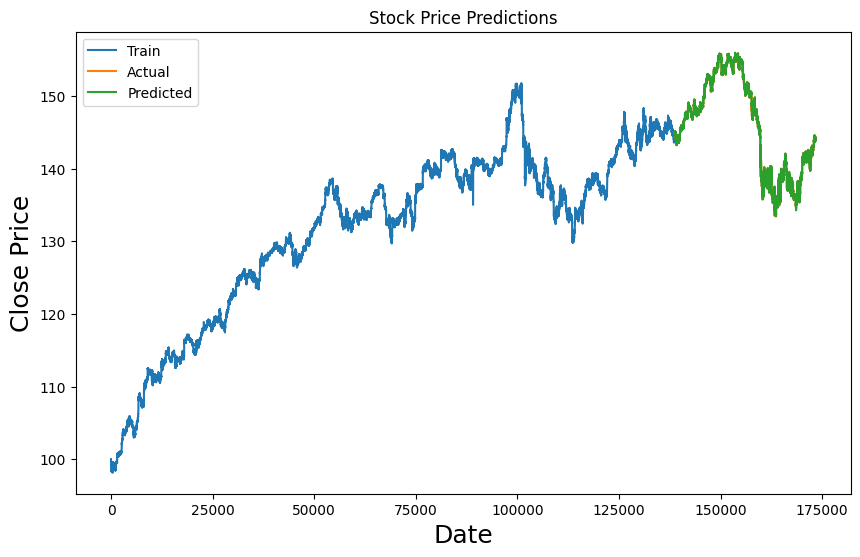

In [ ]:
# Load the data
data = pd.read_csv('/content/drive/MyDrive/OptAlpha_Assignment/s1.csv')
df = pd.DataFrame(data)
df = df.head(173384)

# Converting data frame to NumPy array
dataset = df[['close']].values

# Calculate the training data length (80% of the dataset)
train_data_len = round(len(dataset) * 0.8)

# Scaling the training data between 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_train = scaler.fit_transform(dataset[:train_data_len])

# Prepare training data
x_train, y_train = [], []
window_size = 60  # Adjust the time window here

for i in range(window_size, train_data_len):
    x_train.append(scaled_data_train[i-window_size:i, 0])
    y_train.append(scaled_data_train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(31))
model.add(Dense(1))

# Compile and fit the model
model.compile(optimizer="Nadam", loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=5, epochs=5)

# Prepare test data
test_data = dataset[train_data_len - window_size:, :]
test_data = scaler.fit_transform(test_data)
x_test = [test_data[i-window_size:i, 0] for i in range(window_size, len(test_data))]

# Store actual closing values for test data
y_test = dataset[train_data_len:, :]

# Convert x_test to NumPy array and reshape it
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict the closing value until the original dataset
pred = model.predict(x_test)
pred_inverse = scaler.inverse_transform(pred)

# Print predictions for future 5 days
for i in range(1, 6):
    x_test_future = x_test[-1][1:]
    x_test_future = np.append(x_test_future, [pred[-1]], axis=0)
    x_test_future = x_test_future.reshape(1, window_size, 1)
    pred_future = model.predict(x_test_future)
    print(f"{i}st Day")
    print(scaler.inverse_transform(pred_future))

# Calculate Root Mean Squared Error
rmse = np.sqrt(np.mean(((pred_inverse - y_test)**2)))
print("RMSE:", rmse)

# Plot the graph for training data, predicted data, and actual data
plt.figure(figsize=(10, 6))
plt.title("Stock Price Predictions")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price", fontsize=18)
plt.plot(dataset[:train_data_len], label='Train')
plt.plot(np.arange(train_data_len, len(dataset)), y_test, label='Actual')
plt.plot(np.arange(train_data_len, len(dataset)), pred_inverse, label='Predicted')
plt.legend()
plt.show()


## Clustering Analysis

**Feature Selection for Clustering:**

The features open, high, low, close, and volume are selected from the dataframe df for clustering purposes.

**KMeans Clustering:**

- A KMeans clustering model with 3 clusters (num_clusters = 3) is fitted to the selected features.
- Each data point is assigned to a cluster, and this cluster label is stored in a new column cluster in the dataframe.

## Forecasting

**Target Variable Creation:**

- A new column `next_close` is created by shifting the close prices by one time step, effectively creating a target variable representing the closing price in the next period.

- Another column price_movement is created to indicate whether the price moved up or down. If `next_close` is greater than close, it is labeled as 'up'; otherwise, it is labeled as 'down'.

**Handling Missing Values:**

- The last row, which will have a NaN value in next_close due to the shift operation, is dropped from the dataframe.

**Feature and Target Variable Selection:**

- Features open, high, low, close, volume, and cluster are selected for model training.

- The target variable price_movement is encoded as binary values, with 'up' mapped to 1 and 'down' mapped to 0.

**Train-Test Split:**

- The data is split into training and testing sets using an 80-20 split (test_size=0.2).

**Random Forest Classifier:**

- A Random Forest Classifier is trained on the training set and used to predict the price movement on the test set.

- The accuracy of the model is evaluated using accuracy_score.

**Preparing Data for LSTM Sequence Creation Function:**

- A function create_sequences is defined to transform the data into sequences of a specified length (seq_len = 5).

- This function creates sequences by rolling over the data and generating input-output pairs for the LSTM model.

**Creating Sequences:**

- The create_sequences function is applied to the selected features to create the input (X_seq) and target (y_seq) sequences.

**Train-Validation-Test Split:**

- The sequences are split into training, validation, and test sets with an 80-10-10 split.

**LSTM Model Configuration Parameters for LSTM:**

Parameters such as the number of time steps

```
(n_steps = seq_len),
input features (n_inputs),
number of neurons (n_neurons = 200),
number of layers (n_layers = 2),
learning rate (learning_rate = 0.001),
batch size (batch_size = 50), and
number of epochs (n_epochs = 100) are defined.
```

**TensorFlow Graph Setup:**

- The TensorFlow graph is reset, and placeholders for input (X) and output (y) are defined.

**LSTM Cell with Peephole Connections:**

- LSTM cells with peephole connections are created and stacked into a multi-layer RNN using tf.nn.rnn_cell.MultiRNNCell.

**RNN Outputs and Dense Layer:**

- The RNN outputs are reshaped and passed through a dense layer to produce the final output.

**Loss Function and Optimizer:**

- The Mean Squared Error (MSE) loss function is defined, and the Adam optimizer is used to minimize the loss.

## Training and Evaluation

**Training Loop:**

- The model is trained in a session using mini-batches. The training operation is run in a loop for the specified number of epochs.

- The training and validation MSE are printed at regular intervals.

**Making Predictions:**

- Predictions are made on the training, validation, and test sets using the trained model.

**Plotting Results:**

- The true and predicted values for training, validation, and test sets are plotted for visualization.

**Correct Sign Prediction:**

- The percentage of correct sign predictions (whether the predicted price movement direction matches the actual direction) is calculated for the training, validation, and test sets.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.5257964477022836


<ipython-input-10-7bd754cc0043>:88: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes=True)
<ipython-input-10-7bd754cc0043>:97: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)


0.00 epochs: MSE train/valid = 5335.348633/5493.235840
5.00 epochs: MSE train/valid = 3.345586/3.415818
10.00 epochs: MSE train/valid = 1.295548/1.763080
15.00 epochs: MSE train/valid = 1.456512/1.433175
20.00 epochs: MSE train/valid = 0.441984/0.445177
25.00 epochs: MSE train/valid = 0.208603/0.200887
30.00 epochs: MSE train/valid = 0.261443/0.376303
35.00 epochs: MSE train/valid = 0.245932/0.247046
40.00 epochs: MSE train/valid = 0.434552/0.613579
45.00 epochs: MSE train/valid = 0.092904/0.096296
50.00 epochs: MSE train/valid = 0.102842/0.112134
55.00 epochs: MSE train/valid = 0.246096/0.239032
60.00 epochs: MSE train/valid = 0.021950/0.022423
65.00 epochs: MSE train/valid = 0.013538/0.014568
70.00 epochs: MSE train/valid = 0.012931/0.013037
74.99 epochs: MSE train/valid = 0.010793/0.012052
79.99 epochs: MSE train/valid = 0.009936/0.010931
84.99 epochs: MSE train/valid = 0.024317/0.021899
89.99 epochs: MSE train/valid = 0.013680/0.014905
94.99 epochs: MSE train/valid = 0.014973/0.016

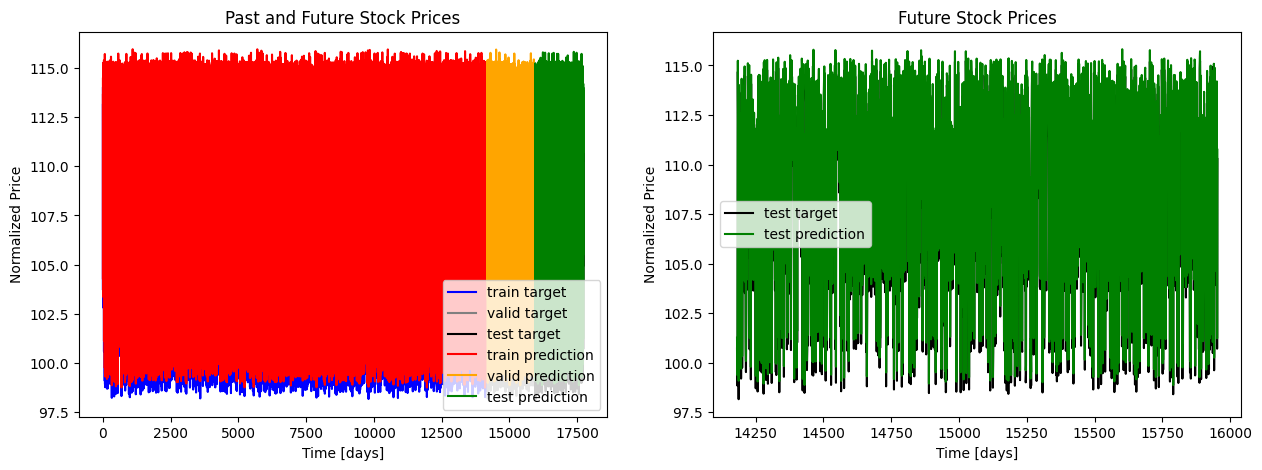

In [ ]:
# Clustering Analysis
# Select features for clustering
X_cluster = df[['open', 'high', 'low', 'close', 'volume']]

# Fit KMeans clustering model
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Forecasting
# Create target variable: price movement in next 5 minutes
df['next_close'] = df['close'].shift(-1)
df['price_movement'] = np.where(df['next_close'] > df['close'], 'up', 'down')

# Drop the last row with NaN in 'next_close'
df.dropna(subset=['next_close'], inplace=True)

# Select features and target variable
X = df[['open', 'high', 'low', 'close', 'volume', 'cluster']]
y = df['price_movement']

# Encode target variable
y = y.map({'up': 1, 'down': 0})

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Prepare the data for LSTM
seq_len = 5

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data.iloc[i:(i + seq_len)].values
        y = data.iloc[i + seq_len]['close']  # or another target column
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create sequences
X_seq, y_seq = create_sequences(df[['open', 'high', 'low', 'close', 'volume', 'cluster']], seq_len)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Parameters for LSTM
n_steps = seq_len
n_inputs = X_train.shape[2]
n_neurons = 200
n_outputs = 1
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100

# Reset graph
tf.reset_default_graph()

# Placeholders
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# LSTM Cell with peephole connections
layers = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu, use_peepholes=True)
          for layer in range(n_layers)]

# MultiRNNCell
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# Dense layer
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:, n_steps-1, :]  # Keep only the last output of sequence

# Loss function and optimizer
loss = tf.reduce_mean(tf.square(outputs - y))  # Mean Squared Error
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Run graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs * X_train.shape[0] / batch_size)):
        start = (iteration * batch_size) % X_train.shape[0]
        end = start + batch_size
        X_batch, y_batch = X_train[start:end], y_train[start:end]
        y_batch_reshaped = y_batch.reshape(-1, 1)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch_reshaped})
        # sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % int(5 * X_train.shape[0] / batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: X_train, y: y_train.reshape(-1, 1)})
            mse_valid = loss.eval(feed_dict={X: X_valid, y: y_valid.reshape(-1, 1)})
            print('%.2f epochs: MSE train/valid = %.6f/%.6f' % (
                iteration * batch_size / X_train.shape[0], mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: X_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: X_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: X_test})

ft = 0  # Feature to plot (0 = open, 1 = close, 2 = high, 3 = low)

# Show predictions
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)

plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='train target')
plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_valid.shape[0]), y_valid,
         color='gray', label='valid target')
plt.plot(np.arange(y_train.shape[0] + y_valid.shape[0],
                   y_train.shape[0] + y_valid.shape[0] + y_test.shape[0]),
         y_test, color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred, color='red',
         label='train prediction')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_valid_pred.shape[0]),
         y_valid_pred, color='orange', label='valid prediction')
plt.plot(np.arange(y_train_pred.shape[0] + y_valid_pred.shape[0],
                   y_train_pred.shape[0] + y_valid_pred.shape[0] + y_test_pred.shape[0]),
         y_test_pred, color='green', label='test prediction')

plt.title('Past and Future Stock Prices')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

plt.subplot(1, 2, 2)

plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
         y_test, color='black', label='test target')
plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_test_pred.shape[0]),
         y_test_pred, color='green', label='test prediction')

plt.title('Future Stock Prices')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Price')
plt.legend(loc='best')

corr_price_development_train = np.sum(np.equal(np.sign(y_train - X_train[:, 0, 3]),
                                               np.sign(y_train_pred - X_train[:, 0, 3])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid - X_valid[:, 0, 3]),
                                               np.sign(y_valid_pred - X_valid[:, 0, 3])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test - X_test[:, 0, 3]),
                                              np.sign(y_test_pred - X_test[:, 0, 3])).astype(int)) / y_test.shape[0]

print('Correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f' % (
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
